In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

# __Autoencoder__

### __Step 1.__ Prepare training data
1. We need to make sure all categorical varialbes are one-hot encoded.
2. Then 'mask' values (replace with 0s?) in corrupted training
3. Add normal/poisson noise to continuous variables (depending on scale)
4. Drop unneeded variables

In [2]:
df_games = pd.read_csv("df_games_output.csv")
df_games.drop(columns=['gameId','gameDate'],inplace=True)

Imputation

In [3]:
# Impute missing values with the mean for numerical columns
for col in df_games.columns:
    if df_games[col].isna().sum() > 0:  # Check if the column has missing values
        if df_games[col].dtype in ['float64', 'int64']:  # Only for numerical columns
            df_games[col].fillna(df_games[col].median(), inplace=True)
        if df_games[col].dtype == 'object':
            df_games[col].fillna('Missing', inplace=True)

C:\Users\Matth\AppData\Local\Temp\ipykernel_15836\3076076711.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_games[col].fillna(df_games[col].median(), inplace=True)
C:\Users\Matth\AppData\Local\Temp\ipykernel_15836\3076076711.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [4]:
# should show NO columns after imputation
for col in df_games.columns:
    if df_games[col].isna().sum() > 0:  # Check if the column has missing values
        print(f"Column {col} still has missing values after imputation.")

Turning `winner` into a PyTorch tensor

In [5]:
# creating team to index mapping for use with home team, away team, and winner one-hot encoded feaures
unique_teams = df_games['hometeamName'].unique()
team_to_index = {team: idx for idx, team in enumerate(unique_teams)}
labels_winner = torch.tensor(df_games['winner'].map(team_to_index).values)
one_hot_winner = F.one_hot(labels_winner,num_classes=len(unique_teams)).float()
print(f"One hot winner shape: {one_hot_winner.shape}")
one_hot_winner
# 33 features for 33 unique teams

One hot winner shape: torch.Size([50581, 33])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
winner_features = ["winner_" + team for team in df_games['hometeamName'].unique()]
winner_features
# df_games['winner'] = df_games['winner'].map(team_to_index)
# df_games['winner']

['winner_Jazz',
 'winner_Kings',
 'winner_Thunder',
 'winner_Hawks',
 'winner_Pistons',
 'winner_Pacers',
 'winner_76ers',
 'winner_Wizards',
 'winner_Timberwolves',
 'winner_Pelicans',
 'winner_Cavaliers',
 'winner_Magic',
 'winner_Raptors',
 'winner_Bucks',
 'winner_Warriors',
 'winner_Celtics',
 'winner_Trail Blazers',
 'winner_Nuggets',
 'winner_Bulls',
 'winner_Rockets',
 'winner_Spurs',
 'winner_Mavericks',
 'winner_Nets',
 'winner_Knicks',
 'winner_Clippers',
 'winner_Suns',
 'winner_Lakers',
 'winner_Heat',
 'winner_Grizzlies',
 'winner_Hornets',
 'winner_Bobcats',
 'winner_SuperSonics',
 'winner_Bullets']

Turning `hometeamName` into a PyTorch tensor

In [7]:
unique_teams = df_games['hometeamName'].unique()
team_to_index = {team: idx for idx, team in enumerate(unique_teams)}
labels_hometeam = torch.tensor(df_games['hometeamName'].map(team_to_index).values)
one_hot_hometeam = F.one_hot(labels_hometeam, num_classes=len(unique_teams)).float()
print(one_hot_hometeam.shape)
one_hot_hometeam

# tensor has a column for each team (index 0 to 32) and the 0th index of the column is 1 if that row is the first team (Jazz)
# 33 home teams

torch.Size([50581, 33])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
hometeam_features = ['hometeam_' + key for key in team_to_index.keys()]
hometeam_features

['hometeam_Jazz',
 'hometeam_Kings',
 'hometeam_Thunder',
 'hometeam_Hawks',
 'hometeam_Pistons',
 'hometeam_Pacers',
 'hometeam_76ers',
 'hometeam_Wizards',
 'hometeam_Timberwolves',
 'hometeam_Pelicans',
 'hometeam_Cavaliers',
 'hometeam_Magic',
 'hometeam_Raptors',
 'hometeam_Bucks',
 'hometeam_Warriors',
 'hometeam_Celtics',
 'hometeam_Trail Blazers',
 'hometeam_Nuggets',
 'hometeam_Bulls',
 'hometeam_Rockets',
 'hometeam_Spurs',
 'hometeam_Mavericks',
 'hometeam_Nets',
 'hometeam_Knicks',
 'hometeam_Clippers',
 'hometeam_Suns',
 'hometeam_Lakers',
 'hometeam_Heat',
 'hometeam_Grizzlies',
 'hometeam_Hornets',
 'hometeam_Bobcats',
 'hometeam_SuperSonics',
 'hometeam_Bullets']

Turning `awayteamName` into a PyTorch tensor

In [9]:
labels_awayteam = torch.tensor(df_games['awayteamName'].map(team_to_index).values)
one_hot_awayteam = F.one_hot(labels_awayteam, num_classes=len(unique_teams)).float()
one_hot_awayteam
# 33 away teams

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [10]:
awayteam_features = ['awayteam_' + key for key in team_to_index.keys()]
awayteam_features

['awayteam_Jazz',
 'awayteam_Kings',
 'awayteam_Thunder',
 'awayteam_Hawks',
 'awayteam_Pistons',
 'awayteam_Pacers',
 'awayteam_76ers',
 'awayteam_Wizards',
 'awayteam_Timberwolves',
 'awayteam_Pelicans',
 'awayteam_Cavaliers',
 'awayteam_Magic',
 'awayteam_Raptors',
 'awayteam_Bucks',
 'awayteam_Warriors',
 'awayteam_Celtics',
 'awayteam_Trail Blazers',
 'awayteam_Nuggets',
 'awayteam_Bulls',
 'awayteam_Rockets',
 'awayteam_Spurs',
 'awayteam_Mavericks',
 'awayteam_Nets',
 'awayteam_Knicks',
 'awayteam_Clippers',
 'awayteam_Suns',
 'awayteam_Lakers',
 'awayteam_Heat',
 'awayteam_Grizzlies',
 'awayteam_Hornets',
 'awayteam_Bobcats',
 'awayteam_SuperSonics',
 'awayteam_Bullets']

Turning `gameType` into a PyTorch tensor

In [11]:
unique_gametypes = df_games['gameType'].unique()
type_to_index = {gametype: idx for idx, gametype in enumerate(unique_gametypes)}
labels_gametype= torch.tensor(df_games['gameType'].map(type_to_index).values)
one_hot_gametype = F.one_hot(labels_gametype, num_classes=len(unique_gametypes)).float()
one_hot_gametype

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]])

In [12]:
gametype_features = ['gametype_' + key for key in type_to_index.keys()]
gametype_features
# 6 game types

['gametype_Regular Season',
 'gametype_Preseason',
 'gametype_Playoffs',
 'gametype_Play-in Tournament',
 'gametype_NBA Cup',
 'gametype_NBA Emirates Cup']

Turning `df_games` into tensor for PyTorch

In [13]:
scaler = StandardScaler()
# scaling the numerical columns
for col in df_games.columns:
    if df_games[col].dtype in ['float64', 'int64']:
        df_games[[col]] = scaler.fit_transform(df_games[[col]])
        
# standardizing all numeric variables in df_games


# creating tensor
tensor_games = torch.tensor(df_games.drop(columns=['hometeamName','awayteamName','winner','gameType']).values)
tensor_numeric = torch.cat([tensor_games,one_hot_hometeam, one_hot_awayteam,one_hot_winner, one_hot_gametype], axis=1)

In [14]:
# feature names
numeric_features = df_games.drop(columns=['hometeamName','awayteamName','winner','gameType']).columns.tolist()
tensor_features = numeric_features +  hometeam_features + awayteam_features + winner_features + gametype_features
tensor_features = [feat.replace(" ","_") for feat in tensor_features]
tensor_features


['homeScore',
 'awayScore',
 'attendance',
 'win_home',
 'assists_home',
 'blocks_home',
 'steals_home',
 'fieldGoalsAttempted_home',
 'fieldGoalsMade_home',
 'fieldGoalsPercentage_home',
 'threePointersAttempted_home',
 'threePointersMade_home',
 'threePointersPercentage_home',
 'freeThrowsAttempted_home',
 'freeThrowsMade_home',
 'freeThrowsPercentage_home',
 'reboundsDefensive_home',
 'reboundsOffensive_home',
 'reboundsTotal_home',
 'foulsPersonal_home',
 'turnovers_home',
 'plusMinusPoints_home',
 'assists_away',
 'blocks_away',
 'steals_away',
 'fieldGoalsAttempted_away',
 'fieldGoalsMade_away',
 'fieldGoalsPercentage_away',
 'threePointersAttempted_away',
 'threePointersMade_away',
 'threePointersPercentage_away',
 'freeThrowsAttempted_away',
 'freeThrowsMade_away',
 'freeThrowsPercentage_away',
 'reboundsDefensive_away',
 'reboundsOffensive_away',
 'reboundsTotal_away',
 'foulsPersonal_away',
 'turnovers_away',
 'plusMinusPoints_away',
 'hometeam_Jazz',
 'hometeam_Kings',
 'hom

### __Step 2.__ Build Model Architecture

In [15]:
class ae(nn.Module):
    def __init__(self):
        super().__init__() # specifies to run parent torch.nn.Module class __init__ method automatically when I initialize the child 'dae' class I'm making.
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Linear(145,36),
            nn.ReLU(),
            nn.Linear(36, 24), 
            nn.ReLU(),
            nn.Linear(24,8)
        )
        # Decoding layers
        self.decoder = nn.Sequential(
            nn.Linear(8,24),
            nn.ReLU(), 
            nn.Linear(24,36), 
            nn.ReLU(),
            nn.Linear(36, 145)
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### __Step 3.__ Instantiate model
* Instantiate loss function for combo of continuous and one-hot encoded variables
> 1. We need to use the proper loss function for one-hot encoded features (binary cross-entropy; BCE).
> 2. Then, specify a composite loss function that includes both binary feature loss (BCE) and continiuous feature loss (MSE).
* Specify gradient descent algorithm

In [16]:
# create instantiation of the model we specified above
model = ae()

def loss_function(prediction, pattern):
    # numeric feature loss
    num_loss_fn = nn.MSELoss()
    num_loss = num_loss_fn(prediction[:,:40], pattern[:,:40])
    
    # CrossEntropy loss to auto apply softmax ans cross entropy loss to continuous outputs that should be treated as logits
    oh_loss_fn = nn.CrossEntropyLoss()
    ht_loss = oh_loss_fn(prediction[:, 40:(40+33)], torch.argmax(pattern[:, 40:(40+33)],dim=1))
    at_loss = oh_loss_fn(prediction[:, 73:(73+33)], torch.argmax(pattern[:, 73:(73+33)],dim = 1))
    win_loss = oh_loss_fn(prediction[:, 106:(106+33)], torch.argmax(pattern[:, 106:(106+33)],dim=1))
    gt_loss = oh_loss_fn(prediction[:, 139:145], torch.argmax(pattern[:, 139:145],dim=1))

    # weights
    weights = torch.tensor([40 / 145,33 / 145,33 / 145,33 / 145,6 / 145])
    losses = torch.stack([num_loss,ht_loss,at_loss,win_loss,gt_loss])
    loss = torch.dot(weights, losses)
    return loss

# AdaM (Adaptive Moment estimation) is a pretty fancy off the shelf algorithm. It involves tracking recent gradient values to dynamically control the learning rate, which aids convergence
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay=1e-8)


__Step 4.__ Set up training regimen

Nested cross-validation: Divide training data into outer folds, then run CV on the outer training folds. Outer fold is for validating number of hidden layers and units


In [17]:
for batch_size in [4,12,24,32,64,128,256]:
    # prepare data for batch training
    loader = DataLoader(tensor_numeric,batch_size = batch_size, shuffle=True)
    # number of training epochs
    epochs = 2
    output = []
    losses = []

    counter = 0
    for epoch in range(1,epochs+1):
        for i, batch in enumerate(loader):
            if (i % 50) == 0: 
                print(f"\rEpoch {epoch} of {epochs}, Batch {i}    ",end='')
            reconstructed = model(batch.float())
            # print(f"\nRECONSTRUCTED: {reconstructed}\nRECONSTRUCTED SHAPE: {reconstructed.shape}")
            loss = loss_function(reconstructed, batch.float())
            # print(f"Batch {i} Loss: {loss.item()}")
            # zero gradients
            optimizer.zero_grad()
            # backprop
            loss.backward()
            # update weights
            optimizer.step()
            # store losses
            losses.append(loss.item())
            # store output6
            counter += 1
            output.append((epoch,loss,counter))
    print(f"Batch size: {batch_size}, Mean loss: {np.mean(losses[-10:])}")

Epoch 2 of 2, Batch 12600    Batch size: 4, Mean loss: 2.710441303253174
Epoch 2 of 2, Batch 4200    Batch size: 12, Mean loss: 2.6631054162979124
Epoch 2 of 2, Batch 2100    Batch size: 24, Mean loss: 2.669318103790283
Epoch 2 of 2, Batch 1550    Batch size: 32, Mean loss: 2.6463277339935303
Epoch 2 of 2, Batch 750    Batch size: 64, Mean loss: 2.642873430252075
Epoch 2 of 2, Batch 350    Batch size: 128, Mean loss: 2.640584182739258
Epoch 2 of 2, Batch 150    Batch size: 256, Mean loss: 2.6372289180755617


In [18]:
def descriptives(list):
    import numpy as np
    print(f'Mean:   {np.mean(list).round(2)}')
    print(f'SD:     {np.std(list).round(2)}')
    print(f'Median: {np.median(list).round(2)}')
    print(f'Min:    {np.min(list).round(2)}')
    print(f'Max:    {np.max(list).round(2)}')

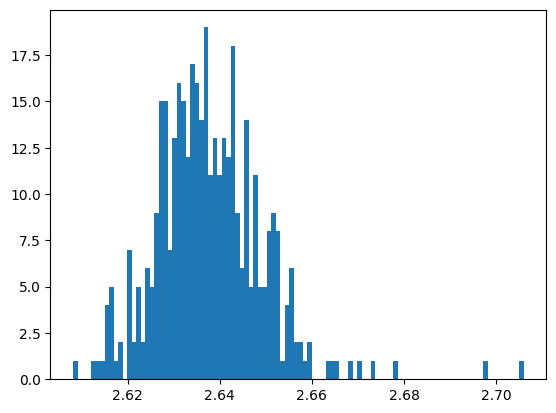

In [19]:
plt.hist(losses,bins=100)
plt.show()

In [20]:
descriptives(losses)

Mean:   2.64
SD:     0.01
Median: 2.64
Min:    2.61
Max:    2.71


In [21]:
idx = list(range(1,len(losses),25))

subset = [losses[i] for i in idx]

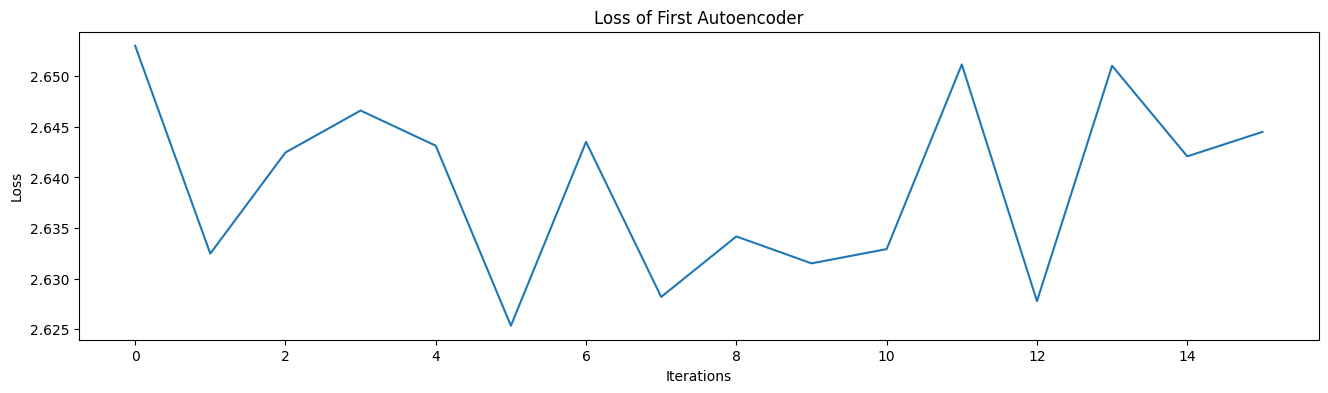

In [22]:
plt.figure(figsize=(16,4))
plt.plot(subset, label='Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss of First Autoencoder')
plt.show()

### Tweaking Loss Function


I tried different things:

* changed the weights

* changed the loss to just be calculated with `win` feature

In [ ]:
# Set weights for loss function
weights = torch.tensor([0.0, 0.3, 0.2, 0.5, 0.00])

def loss_function(prediction, pattern):
    # Numeric feature loss (output remains to be treated as numeric).
    num_loss_fn = nn.MSELoss()

    num_loss = num_loss_fn(prediction[:,:40], pattern[:,:40])
    
    # CrossEntropy loss to auto apply softmax and cross entropy loss (the continuous outputs
    # for these are treated as logits).
    # These are the one-hot encoded features
    oh_loss_fn = nn.CrossEntropyLoss()

    ht_loss = oh_loss_fn(prediction[:, 40:(40+33)], torch.argmax(pattern[:, 40:(40+33)],dim=1))
    
    at_loss = oh_loss_fn(prediction[:, 73:(73+33)], torch.argmax(pattern[:, 73:(73+33)],dim = 1))
    
    win_loss = oh_loss_fn(prediction[:, 106:(106+33)], torch.argmax(pattern[:, 106:(106+33)],dim=1))
    
    gt_loss = oh_loss_fn(prediction[:, 139:145], torch.argmax(pattern[:, 139:145],dim=1))

    losses = torch.stack([num_loss,ht_loss,at_loss,win_loss,gt_loss])
    loss = torch.dot(weights, losses)
    return loss

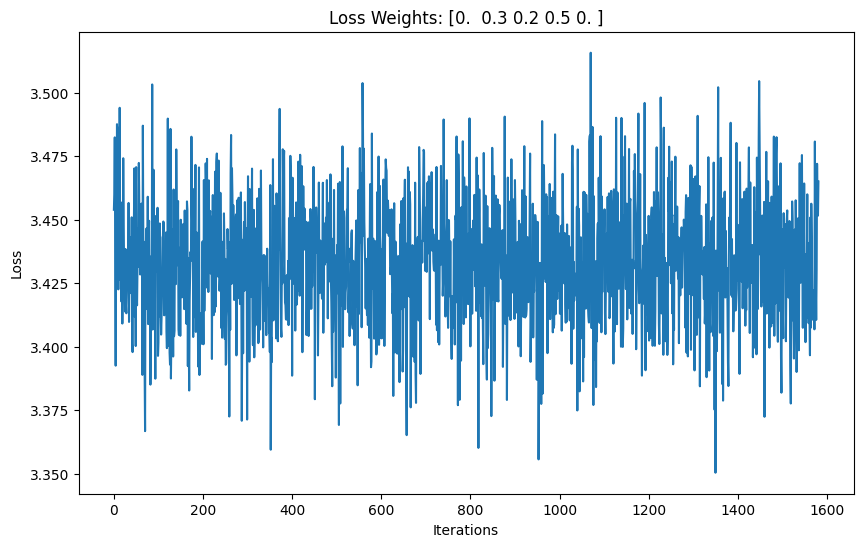

In [25]:
# will keep playing with these values
# mostly for testing purposes

# prepare data for batch training
loader = DataLoader(tensor_numeric,batch_size = 64, shuffle=True)
# number of training epochs
epochs = 2

iterations = epochs * len(loader)

output = []
losses = []

counter = 0
for epoch in range(1,epochs+1):
    for i, batch in enumerate(loader):
        reconstructed = model(batch.float())
        # print(f"\nRECONSTRUCTED: {reconstructed}\nRECONSTRUCTED SHAPE: {reconstructed.shape}")
        loss = loss_function(reconstructed, batch.float())
        # print(f"Batch {i} Loss: {loss.item()}")
        # zero gradients
        optimizer.zero_grad()
        # backprop
        loss.backward()
        # update weights
        optimizer.step()
        # store losses
        losses.append(loss.item())
        # store output6
        counter += 1
        output.append((epoch,loss,counter))
        if(i % 25):
            clear_output(wait=True)
            plt.figure(figsize=(10,6))
            plt.plot(losses, label='Losses')
            plt.xlabel("Iterations")
            # plt.xlim(0, iterations)
            # plt.ylim(0, 3)
            plt.ylabel("Loss")
            plt.title(f"Loss Weights: {np.array(weights.
            tolist()).round(2)}")
            plt.show()